<a href="https://colab.research.google.com/github/Anvarka/RecSys/blob/master/HW_1_RECSYS_HSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! unzip /content/drive/MyDrive/ml-1m.zip
! pip install implicit

Archive:  /content/drive/MyDrive/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
     |████████████████████████████████| 1.1 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606566 sha256=ad734cb5a75dce23a02fa4bbee15c014ccda4bd83d7021ce38cdd4d85d810c2f
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP на implicit данных

Мягкий дедлайн 13 Октября (пишутся замечания, выставляется оценка, есть возможность исправить до жесткого дедлайна)

Жесткий дедлайн 20 Октября (Итоговая проверка)

In [3]:
!pip install lightfm
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp

from lightfm.datasets import fetch_movielens

     |████████████████████████████████| 310 kB 5.4 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705345 sha256=c6044e27445ff2815bf08224ddfef8668d140b9b4e0c13505a1e56aff10c07b5
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [4]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')
ratings

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [5]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python')
movie_info

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Explicit данные

In [ ]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [ ]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [ ]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [ ]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [ ]:
model.fit(user_item_t_csr)

  0%|          | 0/100 [00:00<?, ?it/s]

Построим похожие фильмы по 1 movie_id = Истории игрушек

In [ ]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                        for x in model.similar_items(item_id)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [ ]:
get_similars(1, model)

/usr/local/lib/python3.7/dist-packages/implicit/gpu/matrix_factorization_base.py:108: RuntimeWarning: invalid value encountered in true_divide
  scores /= self._item_norms_host[itemid]


['Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [ ]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() 
                                            for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [ ]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [ ]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [ ]:
get_recommendations(4, model)

['Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )',
 'Series([], )']

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

Заведем функцию для similars:

In [6]:
def get_similars(item_id, model):
    movie_id = movie_info[movie_info["movie_id"] == item_id]
    print(f"Similar to {movie_id['name'].item()} with category {movie_id['category'].item()}:")
      
    similarities = model.similar_items(item_id)
    
    for number, sim_movie_id in enumerate(similarities):
        _movie = movie_info[movie_info["movie_id"] == sim_movie_id]
        print(f"{number + 1}) {_movie['name'].item()} with category {_movie['category'].item()}")

Заведем функцию для рекомендаций для конкретного user-a:

In [8]:
def get_recommendations(user_id, model):
    print(f"Reccomend for user {user_id}:")
      
    recommends = model.recommend(user_id)
    
    for number, recommend_movie in enumerate(recommends):
        _movie = movie_info[movie_info["movie_id"] == recommend_movie]
        print(f"{number + 1}) {_movie['name'].item()} with category {_movie['category'].item()}")

Функция для построения графика loss:

In [31]:
def get_plot_of_loss(_values):
    x = np.arange(0, len(_values))
    plt.xlabel("iterations")
    plt.ylabel("rmse")
    plt.plot(x, _values)
    plt.show()

### Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [10]:
import numpy as np
from tqdm import tqdm

In [11]:
ratings["rating"].mean()

3.581564453029317

In [12]:
movies = np.array(ratings["movie_id"].unique())
users = np.array(ratings["user_id"].unique())


# нумеруем user_id для строчек матрицы
dict_users = {}
dict__reverse_users = {} 
for i in range(len(users)):
  dict_users[users[i]] = i
  dict__reverse_users[i] = users[i]

# нумеруем movie_id для столбцов матрицы
dict_movies = {}
dict__reverse_movies = {} 
for i in range(len(movies)):
  dict_movies[movies[i]] = i
  dict__reverse_movies[i] = movies[i]

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

class SVD_model:
    def __init__(self, alpha:float, weight_decay, epochs=60, hidden_dim=64):
        self.alpha = alpha
        self.epochs = epochs
        self.hidden_dim = hidden_dim
        self.weight_decay = weight_decay
        self.b_u = 1
        self.b_v = 2
        self.mu = 3.5
        self.losses = []
    
    def fit(self, user_movie_sparse):
        self.losses = []
   
        self.u = np.random.normal(loc=0, scale=1, size=(user_movie_sparse.shape[0], self.hidden_dim))
        self.v = np.random.normal(loc=0, scale=1, size=(user_movie_sparse.shape[1], self.hidden_dim))

        for i in tqdm(range(self.epochs)):
            dQ = 2 * np.asarray(self.u @ self.v.T + self.b_u + self.b_v + self.mu  - user_movie_sparse)

            delta_L_u = dQ @ self.v + self.weight_decay * self.u
            delta_L_v = dQ.T @ self.u + self.weight_decay * self.v 

            self.u -= self.alpha * delta_L_u
            self.v -= self.alpha * delta_L_v
            self.losses.append(np.sqrt(np.sqrt(np.mean(dQ ** 2))))

  
    def similar_items(self, item_id, n=10):
        sims = cosine_similarity(self.v)[item_id]
        return np.argsort(sims)[-(n + 1) : -1][::-1]


    def recommend(self, user_id, n=10):

        sims = cosine_similarity(self.v, self.u[user_id][np.newaxis, :]).flatten()
        return np.argsort(sims)[-(n + 1) : -1][::-1]



In [26]:
import numpy as np

user_movie_sparse = sp.coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))

regr = SVD_model(alpha=0.00001, weight_decay=1e-2, epochs=1000)
regr.fit(user_movie_sparse)

 10%|█         | 101/1000 [01:16<11:17,  1.33it/s]


KeyboardInterrupt: ignored

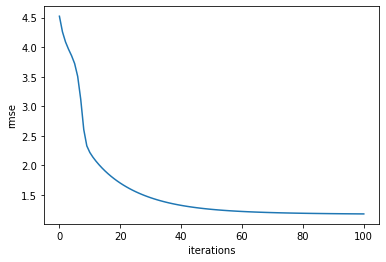

In [32]:
import matplotlib.pyplot as plt

get_plot_of_loss(regr.losses)

In [29]:
get_similars(2, regr)

Similar to Jumanji (1995) with category Adventure|Children's|Fantasy:
1) U.S. Marshalls (1998) with category Action|Thriller
2) Toys (1992) with category Action|Comedy|Fantasy
3) Boy Who Could Fly, The (1986) with category Drama|Fantasy
4) My Blue Heaven (1990) with category Comedy
5) Labyrinth (1986) with category Adventure|Children's|Fantasy
6) Indochine (1992) with category Drama|Romance
7) Tommy Boy (1995) with category Comedy
8) Dancer, Texas Pop. 81 (1998) with category Comedy|Drama
9) Rosie (1998) with category Drama
10) Fire Down Below (1997) with category Action|Drama|Thriller


In [30]:
get_recommendations(4, regr)

Reccomend for user 4:
1) Aliens (1986) with category Action|Sci-Fi|Thriller|War
2) Dogma (1999) with category Comedy
3) Star Wars: Episode VI - Return of the Jedi (1983) with category Action|Adventure|Romance|Sci-Fi|War
4) Mask, The (1994) with category Comedy|Crime|Fantasy
5) Chicken Run (2000) with category Animation|Children's|Comedy
6) Frequency (2000) with category Drama|Thriller
7) Payback (1999) with category Action|Thriller
8) Abyss, The (1989) with category Action|Adventure|Sci-Fi|Thriller
9) Full Metal Jacket (1987) with category Action|Drama|War
10) Human Traffic (1999) with category Drama


### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

In [33]:
# movies = np.array(implicit_ratings["movie_id"].unique())
# users = np.array(implicit_ratings["user_id"].unique())
# dict_users = {}

# for i in range(len(users)):
#   dict_users[users[i]] = i

# dict_movies = {} 
# for i in range(len(movies)):
#   dict_movies[movies[i]] = i

# mov_users_implicit = np.full(shape=[len(users), len(movies)], fill_value=0)

# movies = np.array(implicit_ratings["movie_id"])
# users = np.array(implicit_ratings["user_id"])
# rank = np.array(implicit_ratings["rating"])

# for ind, row in implicit_ratings.iterrows():
#     user_id = row["user_id"]
#     movie_id = row["movie_id"]
#     rating = row["rating"]
#     i_ = dict_users[user_id]
#     j_ = dict_movies[movie_id]

#     mov_users_implicit[i_][j_] = rating

In [48]:
class ALS_model:
    def __init__(self, alpha:float, weight_decay, epochs=60, hidden_dim=64):
        self.alpha = alpha
        self.epochs = epochs
        self.hidden_dim = hidden_dim
        self.weight_decay = weight_decay
        self.losses = []
    
    def fit(self, user_movie_sparse):
        self.losses = []
        
        self.u = np.random.normal(loc=0, scale=1, size=(user_movie_sparse.shape[0], self.hidden_dim))
        self.v = np.random.normal(loc=0, scale=1, size=(user_movie_sparse.shape[1], self.hidden_dim))

        for i in tqdm(range(self.epochs)):
            score = np.asarray(self.u @ self.v.T - user_movie_sparse)

            if i % 2 == 0:
                delta_L_u = 2 * (score @ self.v + self.weight_decay * self.u)
                delta_L_v = 0
            else:
                delta_L_u = 0
                delta_L_v = 2 * (score.T @ self.u + self.weight_decay *self.v)

            self.u -= self.alpha * delta_L_u
            self.v -= self.alpha * delta_L_v
            self.losses.append(np.sqrt(np.mean(score ** 2)))

    def similar_items(self, item_id, n=10):
        sims = cosine_similarity(self.v)[item_id]
        return np.argsort(sims)[-(n + 1) : -1][::-1]


    def recommend(self, user_id, n=10):
        sims = cosine_similarity(self.v, self.u[user_id][np.newaxis, :]).flatten()
        return np.argsort(sims)[-(n + 1) : -1][::-1]

In [49]:
import numpy as np

als_model = ALS_model(alpha=0.0001, epochs=1000, weight_decay=1e-2)
als_model.fit(user_movie_sparse)

 30%|███       | 303/1000 [02:23<05:30,  2.11it/s]


KeyboardInterrupt: ignored

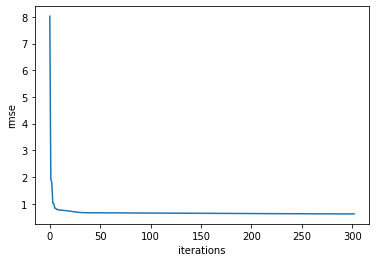

In [51]:
get_plot_of_loss(als_model.losses)

In [52]:
get_similars(1, regr)

Similar to Toy Story (1995) with category Animation|Children's|Comedy:
1) Beetlejuice (1988) with category Comedy|Fantasy
2) Stigmata (1999) with category Thriller
3) Nightmare Before Christmas, The (1993) with category Children's|Comedy|Musical
4) Mary Poppins (1964) with category Children's|Comedy|Musical
5) Wrong Trousers, The (1993) with category Animation|Comedy
6) Seven (Se7en) (1995) with category Crime|Thriller
7) Fear and Loathing in Las Vegas (1998) with category Comedy|Drama
8) NeverEnding Story, The (1984) with category Adventure|Children's|Fantasy
9) Honey, I Shrunk the Kids (1989) with category Adventure|Children's|Comedy|Fantasy|Sci-Fi
10) Slaughterhouse (1987) with category Horror


In [53]:
get_recommendations(1, regr)

Reccomend for user 1:
1) X-Men (2000) with category Action|Sci-Fi
2) Star Wars: Episode IV - A New Hope (1977) with category Action|Adventure|Fantasy|Sci-Fi
3) Shakespeare in Love (1998) with category Comedy|Romance
4) Sleepy Hollow (1999) with category Horror|Romance
5) Toy Story 2 (1999) with category Animation|Children's|Comedy
6) Muppets From Space (1999) with category Children's|Comedy
7) Aliens (1986) with category Action|Sci-Fi|Thriller|War
8) Sixth Sense, The (1999) with category Thriller
9) Nights of Cabiria (Le Notti di Cabiria) (1957) with category Drama
10) Amadeus (1984) with category Drama


### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

In [ ]:
from collections import defaultdict
# movies = np.array(implicit_ratings["movie_id"])
# users = np.array(implicit_ratings["user_id"])


movies = np.array(ratings["movie_id"].unique())
users = np.array(ratings["user_id"].unique())

mov_users_data = np.full(shape=[len(users), len(movies)], fill_value=0)

dict_users = {}
for i in range(len(users)):
  dict_users[users[i]] = i

dict_movies = {} 
for i in range(len(movies)):
  dict_movies[movies[i]] = i


positives = defaultdict(list)
negatives = defaultdict(list)

for user_id, df in ratings.groupby("user_id"):
    positives[user_id] = np.array(list([df[df['rating'] >= 4]['movie_id'].values])).flatten()
    negatives[user_id] = np.array(list([df[df['rating'] < 4]['movie_id'].values])).flatten()

In [ ]:
mov_users_data.shape

(6040, 3706)

In [ ]:
import numpy as np
from tqdm import tqdm


In [ ]:
class GradientLR:
    def __init__(self, alpha:float, epochs=60, lambda_=0.01, hidden_dim=64):
        self.alpha = alpha
        self.epochs = epochs
        self.hidden_dim = hidden_dim
        self.lambda_ = lambda_

    def get_negative_item(self, user, movies, count):
        if len(negatives[user]) == 0:
            for movie in movies:
                if not movie in positives[user]:
                    negatives[user] = np.array([movie])
                    break

        return np.random.choice(negatives[user], count)

    def get_positive_item(self, user, movies, count):
        if len(positives[user]) == 0:
            for movie in movies:
                if not movie in negatives[user]:
                    positives[user] = np.array([movie])
                    break

        return np.random.choice(positives[user], count)

    def get_correct_item_ids(self, user, movies, dict_movies, count):

        positive_ids = self.get_positive_item(user, movies, count=count)
        negative_ids = self.get_negative_item(user, movies, count=count)

        positive_ids = np.array(list(dict_movies[k] for k in positive_ids))
        negative_ids = np.array(list(dict_movies[k] for k in negative_ids))
        return positive_ids, negative_ids


    def fit(self, ratings):
        movies = np.array(ratings["movie_id"].unique())

        dict_movies = {}
        for i in  range(len(movies)):
            dict_movies[movies[i]] = i

        users = np.array(ratings["user_id"].unique())

        positives_emb = np.random.normal(size=(len(users), self.hidden_dim))
        self.u = np.random.normal(loc=0, scale=1, size=(len(users), self.hidden_dim))
        self.v = np.random.normal(loc=0, scale=1, size=(len(movies), self.hidden_dim))

        for i in tqdm(range(self.epochs)): 

            positive_user_items = {}
            negative_user_items = {} 

            # sum exp(-x)/(1+exp(-x)) = -1/(exp(sum(x))+1)
            # sum(x_uij) = sum(x_ui - x_uj)
            # x_ui = U @ V_pos.T
            # x_uj = U @ V_neg.T
            sum_diff = 0
            for j in range(len(users)):
                positive_ids, negative_ids = self.get_correct_item_ids(users[j], movies, dict_movies, count=32)

                positive_user_items[j] = positive_ids
                negative_user_items[j] = negative_ids

                sum_diff += self.u[j] @ (self.v[positive_ids] - self.v[negative_ids]).T
            sum_diff = np.array(sum_diff, dtype=np.float128)
            numerator = 1.0 / (1.0 + np.exp(sum_diff))

            for j in range(len(users)):

                score_positive = self.v[positive_user_items[j]]
                score_negative = self.v[negative_user_items[j]]

                temp = self.u[j]
                # if theta = U    
                differential = score_positive - score_negative
                
                self.u[j] += self.alpha * (numerator.T @ differential - self.lambda_ * temp)

                # if theta = score_pos
                differential = temp
                res = np.outer(numerator, differential.T)
                self.v[positive_ids] = self.v[positive_ids] + self.alpha * (res - self.lambda_ * score_positive)

                # if theta = score_pos
                differential = temp
                self.v[negative_ids] = self.v[negative_ids] + self.alpha * (-res - self.lambda_ * score_negative)
            score = self.u @ self.v.T        
            print(np.mean(score**2))

In [ ]:
import numpy as np

regr = GradientLR(alpha=0.01, epochs=50, lambda_=1)
regr.fit(ratings)

  2%|▏         | 1/50 [00:02<01:50,  2.26s/it]

64.80140648322089


  4%|▍         | 2/50 [00:04<01:46,  2.21s/it]

64.34938538927786


  6%|▌         | 3/50 [00:06<01:42,  2.17s/it]

63.86862747884723


  8%|▊         | 4/50 [00:08<01:39,  2.16s/it]

63.301600112800536


 10%|█         | 5/50 [00:10<01:37,  2.17s/it]

62.815159880819635


 12%|█▏        | 6/50 [00:13<01:35,  2.17s/it]

62.29655200803089


 14%|█▍        | 7/50 [00:15<01:32,  2.16s/it]

61.68117296000909


 16%|█▌        | 8/50 [00:17<01:30,  2.16s/it]

61.037559755223164


 18%|█▊        | 9/50 [00:19<01:28,  2.17s/it]

60.39161283869193


 20%|██        | 10/50 [00:21<01:26,  2.16s/it]

59.861049101549945


 22%|██▏       | 11/50 [00:23<01:24,  2.15s/it]

59.27112288000134


 24%|██▍       | 12/50 [00:25<01:21,  2.16s/it]

58.7317280082329


 26%|██▌       | 13/50 [00:28<01:19,  2.15s/it]

58.16334455526974


 28%|██▊       | 14/50 [00:30<01:17,  2.15s/it]

57.68594174234879


 30%|███       | 15/50 [00:32<01:15,  2.17s/it]

57.17889634706134


 32%|███▏      | 16/50 [00:34<01:13,  2.17s/it]

56.664478668630686


 34%|███▍      | 17/50 [00:36<01:11,  2.16s/it]

56.12395178608889


 36%|███▌      | 18/50 [00:38<01:09,  2.17s/it]

55.5938205037679


 38%|███▊      | 19/50 [00:41<01:06,  2.15s/it]

55.152474525270286


 40%|████      | 20/50 [00:43<01:04,  2.15s/it]

54.76540632057679


 42%|████▏     | 21/50 [00:45<01:02,  2.15s/it]

54.31986007154113


 44%|████▍     | 22/50 [00:47<01:00,  2.15s/it]

53.99194132563702


 46%|████▌     | 23/50 [00:49<00:58,  2.15s/it]

53.55198764613173


 48%|████▊     | 24/50 [00:51<00:56,  2.17s/it]

53.170938095129685


 50%|█████     | 25/50 [00:54<00:54,  2.18s/it]

52.953942440840926


 52%|█████▏    | 26/50 [00:56<00:52,  2.18s/it]

52.58824685374936


 54%|█████▍    | 27/50 [00:58<00:49,  2.16s/it]

52.358505450530224


 56%|█████▌    | 28/50 [01:00<00:47,  2.16s/it]

52.1113753835327


 58%|█████▊    | 29/50 [01:02<00:45,  2.15s/it]

51.88400973378664


 60%|██████    | 30/50 [01:04<00:42,  2.14s/it]

51.59035078021666


 62%|██████▏   | 31/50 [01:06<00:40,  2.13s/it]

51.543427678435826


 64%|██████▍   | 32/50 [01:09<00:38,  2.13s/it]

51.21952254123395


 66%|██████▌   | 33/50 [01:11<00:36,  2.12s/it]

50.93082630726924


 68%|██████▊   | 34/50 [01:13<00:33,  2.12s/it]

50.59153772788063


 70%|███████   | 35/50 [01:15<00:31,  2.11s/it]

50.28438194905757


 72%|███████▏  | 36/50 [01:17<00:29,  2.12s/it]

50.10730811786037


 74%|███████▍  | 37/50 [01:19<00:27,  2.12s/it]

49.7303700532748


 76%|███████▌  | 38/50 [01:21<00:25,  2.11s/it]

49.61476886192727


 78%|███████▊  | 39/50 [01:23<00:23,  2.13s/it]

49.36808080863909


 80%|████████  | 40/50 [01:25<00:21,  2.13s/it]

49.15852209209732


 82%|████████▏ | 41/50 [01:28<00:19,  2.12s/it]

49.071501979914565


 84%|████████▍ | 42/50 [01:30<00:16,  2.11s/it]

48.85408521420568


 86%|████████▌ | 43/50 [01:32<00:14,  2.11s/it]

48.66145941454001


 88%|████████▊ | 44/50 [01:34<00:12,  2.12s/it]

48.40350772826083


 90%|█████████ | 45/50 [01:36<00:10,  2.12s/it]

48.22095811428433


 92%|█████████▏| 46/50 [01:38<00:08,  2.10s/it]

48.11733935426052


 94%|█████████▍| 47/50 [01:40<00:06,  2.10s/it]

47.89377459654419


 96%|█████████▌| 48/50 [01:42<00:04,  2.11s/it]

47.60749868295995


 98%|█████████▊| 49/50 [01:44<00:02,  2.10s/it]

47.42470978008911


100%|██████████| 50/50 [01:47<00:00,  2.14s/it]

47.161271577212695


### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных